[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Leo-ChenYZ/Explainable-AI/blob/main/Assignments/Assignment_3/Assignment_3.ipynb)

# Assignment 3
Leo Chen

## Recidivism Risk – COMPAS Dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from scipy.stats import chi2_contingency
import itertools
from sklearn.inspection import PartialDependenceDisplay

In [2]:
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df_compas = pd.read_csv(url)

# Filter relevant columns and preprocess
features = ['age', 'sex', 'race', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'c_charge_degree']
df = df_compas[features + ['two_year_recid']].dropna()
df = df[df['c_charge_degree'].isin(['F', 'M'])]  # Filter valid degrees

# Encode categoricals
df = df.copy()
df['sex'] = df['sex'].astype('category').cat.codes
df['race'] = df['race'].astype('category').cat.codes
df['c_charge_degree'] = df['c_charge_degree'].astype('category').cat.codes

X = df[features]
y = df['two_year_recid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_compas = RandomForestClassifier(random_state=42)
model_compas.fit(X_train, y_train)
print(classification_report(y_test, model_compas.predict(X_test)))

              precision    recall  f1-score   support

           0       0.68      0.68      0.68       823
           1       0.57      0.57      0.57       620

    accuracy                           0.63      1443
   macro avg       0.62      0.62      0.62      1443
weighted avg       0.63      0.63      0.63      1443



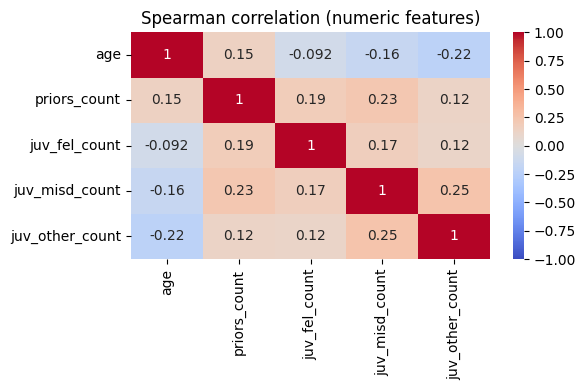

Cramér’s V (categorical-categorical):
  sex vs race: 0.067
  sex vs c_charge_degree: 0.052
  race vs c_charge_degree: 0.090

Correlation ratio (categorical -> numeric):
  sex -> age: eta^2=0.000
  sex -> priors_count: eta^2=0.014
  sex -> juv_fel_count: eta^2=0.003
  sex -> juv_misd_count: eta^2=0.002
  sex -> juv_other_count: eta^2=0.003
  race -> age: eta^2=0.037
  race -> priors_count: eta^2=0.044
  race -> juv_fel_count: eta^2=0.006
  race -> juv_misd_count: eta^2=0.009
  race -> juv_other_count: eta^2=0.004
  c_charge_degree -> age: eta^2=0.007
  c_charge_degree -> priors_count: eta^2=0.021
  c_charge_degree -> juv_fel_count: eta^2=0.002
  c_charge_degree -> juv_misd_count: eta^2=0.001
  c_charge_degree -> juv_other_count: eta^2=0.001

RandomForest feature importances:
 age                0.513
priors_count       0.283
race               0.074
juv_other_count    0.031
c_charge_degree    0.027
sex                0.025
juv_misd_count     0.025
juv_fel_count      0.021
dtype: float64

In [3]:
# EDA: Correlation among features

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (6,4)

numeric_cols = ['age', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count']
cat_cols = ['sex', 'race', 'c_charge_degree']

# 1) Numeric-numeric: Spearman correlation
corr_spear = X[numeric_cols].corr(method='spearman')
plt.figure(figsize=(6,4))
sns.heatmap(corr_spear, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Spearman correlation (numeric features)')
plt.tight_layout()
plt.show()

# 2) Categorical-categorical: Cramér’s V (bias-corrected)
def cramers_v_corrected(x, y):
    confusion = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion)[0]
    n = confusion.to_numpy().sum()
    phi2 = chi2 / n
    r, k = confusion.shape
    # Bias correction (Bergsma 2013)
    phi2_corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    r_corr = r - (r-1)**2/(n-1)
    k_corr = k - (k-1)**2/(n-1)
    denom = min(k_corr-1, r_corr-1)
    return np.sqrt(phi2_corr / denom) if denom > 0 else 0.0

cramers_results = []
for a, b in itertools.combinations(cat_cols, 2):
    v = cramers_v_corrected(X[a], X[b])
    cramers_results.append((a, b, v))

print("Cramér’s V (categorical-categorical):")
for a, b, v in cramers_results:
    print(f"  {a} vs {b}: {v:.3f}")

# 3) Categorical-numeric: Correlation ratio (eta-squared)
def correlation_ratio(categories, measurements):
    # categories: vector of ints (k categories), measurements: numeric
    cats = pd.Series(categories).astype(int)
    y = np.array(measurements, dtype=float)
    groups = [y[cats == k] for k in np.unique(cats)]
    n_total = len(y)
    y_mean = y.mean()
    ss_between = sum(len(g) * (g.mean() - y_mean)**2 for g in groups if len(g) > 0)
    ss_total = ((y - y_mean)**2).sum()
    return (ss_between / ss_total) if ss_total > 0 else 0.0
    # The above code snippet was generated using GPT-5 on 09/29/25 at 12:18a.

print("\nCorrelation ratio (categorical -> numeric):")
for c in cat_cols:
    for ncol in numeric_cols:
        eta2 = correlation_ratio(X[c], X[ncol])
        print(f"  {c} -> {ncol}: eta^2={eta2:.3f}")

# feature importances
importances = pd.Series(model_compas.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nRandomForest feature importances:\n", importances.round(3))

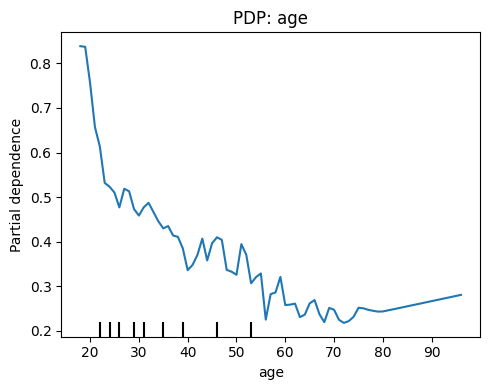

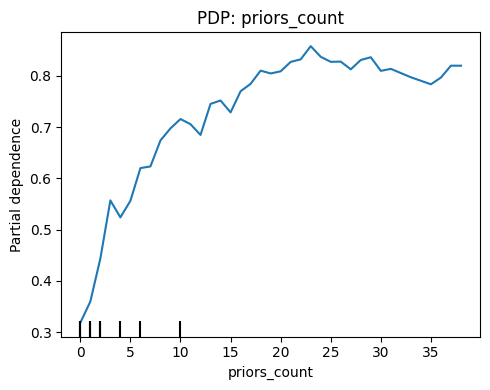

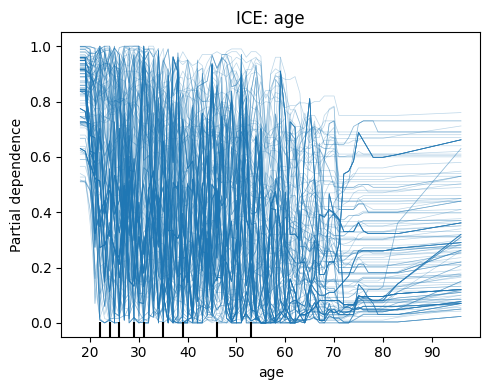

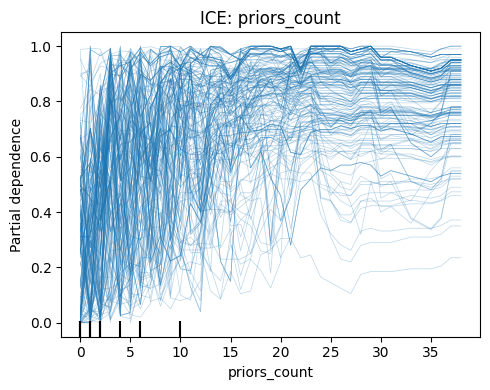

In [4]:
# PDP and ICE

pd_num_features = ['age', 'priors_count']

# PDP for numeric features
for feat in pd_num_features:
    fig, ax = plt.subplots(1, 1, figsize=(5,4))
    PartialDependenceDisplay.from_estimator(
        model_compas, X, [feat], kind='average', ax=ax
    )
    ax.set_title(f'PDP: {feat}')
    plt.tight_layout()
    plt.show()

# ICE for numeric features (subsample to reduce clutter)
for feat in pd_num_features:
    fig, ax = plt.subplots(1, 1, figsize=(5,4))
    PartialDependenceDisplay.from_estimator(
        model_compas, X, [feat], kind='individual', subsample=200, random_state=42, ax=ax
    )
    ax.set_title(f'ICE: {feat}')
    plt.tight_layout()
    plt.show()

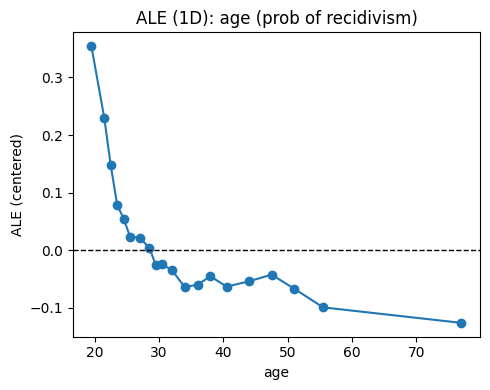

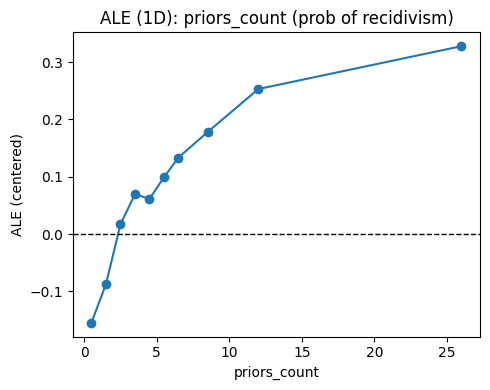

In [5]:
# ALE (1D) for numeric features

def ale_1d_binary(model_proba_func, X_in, feature_name, bins=20):
    X_np = X_in.to_numpy().copy()
    j = X_in.columns.get_loc(feature_name)
    xj = X_np[:, j].astype(float)

    # Quantile bins
    qs = np.linspace(0, 1, bins + 1)
    edges = np.unique(np.quantile(xj, qs))
    if len(edges) < 3:
        edges = np.unique(xj)
    if len(edges) < 3:
        raise ValueError(f"Not enough unique values in {feature_name} for ALE bins.")

    mean_deltas = []
    counts = []

    for i in range(len(edges) - 1):
        lo, hi = edges[i], edges[i + 1]
        in_bin = (xj >= lo) & (xj < hi) if i < len(edges) - 2 else (xj >= lo) & (xj <= hi)
        idx = np.where(in_bin)[0]
        counts.append(len(idx))
        if len(idx) == 0:
            mean_deltas.append(0.0)
            continue

        X_low = X_np[idx, :].copy()
        X_high = X_np[idx, :].copy()
        X_low[:, j] = lo
        X_high[:, j] = hi

        p_low = model_proba_func(X_low)
        p_high = model_proba_func(X_high)
        mean_deltas.append(np.mean(p_high - p_low))

    mean_deltas = np.array(mean_deltas, dtype=float)
    counts = np.array(counts, dtype=float)
    # ALE at bin midpoints: sum of previous mean_deltas + half current
    cumsum_prev = np.cumsum(mean_deltas) - mean_deltas
    ale_mid = cumsum_prev + 0.5 * mean_deltas
    # The above code snippet was generated using GPT-5 on 09/29/25 at 12:50a.

    # Centering (weighted by empirical frequency in each bin)
    total = counts.sum()
    if total > 0:
        center = np.sum(ale_mid * counts) / total
    else:
        center = ale_mid.mean()
    ale_centered = ale_mid - center

    bin_mids = 0.5 * (edges[:-1] + edges[1:])
    return bin_mids, ale_centered, counts, edges

# proba function for class=1
proba1 = lambda Xarr: model_compas.predict_proba(Xarr)[:, 1]

ale_features = ['age', 'priors_count']
for feat in ale_features:
    mids, ale_vals, counts, edges = ale_1d_binary(proba1, X, feat, bins=20)
    fig, ax = plt.subplots(figsize=(5,4))
    ax.plot(mids, ale_vals, marker='o', linewidth=1.5)
    ax.axhline(0, color='k', linestyle='--', linewidth=1)
    ax.set_title(f'ALE (1D): {feat} (prob of recidivism)')
    ax.set_xlabel(feat)
    ax.set_ylabel('ALE (centered)')
    plt.tight_layout()
    plt.show()
    # The above code snippet was generated using GPT-5 on 09/29/25 at 01:25a.

The model's behavior is dominated by age and priors_count, consistent with their large RandomForest importances (about 0.51 and 0.28). Correlation results help set expectations for the plots: numeric-numeric associations are modest, with priors_count positively related to the juvenile counts and age weakly negatively related to them. Categorical variables show very small mutual association (Cramér's V all below 0.1) and weak links to numerics (largest correlation ratio around 0.044 for race→priors_count). In short, the features are not strongly collinear.

For age, the PDP falls sharply from late teens through the early thirties, then flattens, and shows a small uptick at the oldest ages. The rug marks reveal that data are sparse in the far right tail, so the PDP there reflects the model's predictions for atypical combinations, such as "very old age with average or high counts," which rarely occur. The ALE curve, which accumulates local effects only where data exist, keeps decreasing smoothly across the range and does not exhibit the late-life rebound. This divergence strongly suggests that the PDP's uptick is an extrapolation artifact created by breaking the negative association between age and the count features. ICE lines for age underline substantial heterogeneity: many individuals' predicted risk drops quickly with age, but baselines and slopes vary, indicating interactions with other variables.

For priors_count, PDP and ALE tell nearly the same story. Both show a steep increase in risk from zero to a handful of priors, followed by a slower rise and a relatively stable stay at higher counts, which is consistent with diminishing marginal effects. The ICE plot is largely monotone increasing for individual cases, but the vertical spread shows different baselines and slopes across people, again pointing to interactions. Here the agreement between PDP and ALE is tighter because most of the evaluation grid lies in data-dense regions and the correlations with other variables, while present, are not strong enough to create the kind of tail instability seen for age.

The correlation analysis explains the PDP-ALE differences. Because age is mildly negatively correlated with the various count features, PDP's practice of sweeping age while averaging over the rest constructs unrealistic combinations at high ages, which can bend the PDP upward even when the true local effect remains negative. ALE avoids this by estimating changes within observed neighborhoods, so it is more reliable at the extremes. For priors_count, the grid stays close to typical profiles for much of the range, so PDP and ALE align. ICE complements both by revealing the range of individual responses hidden by averages, making clear that interactions matter even when global correlations are modest.

Overall, the three views are consistent on the main effects: younger age increases risk and more priors increase risk too, with the largest marginal jumps at low priors. Where PDP and ALE diverge, primarily in sparse regions, the ALE shape is the one to trust.